In [1]:
import torch
import matplotlib.pyplot as plt

from model import Model

In [2]:
# 0. define a model to fit
# this FitModel build a model with CEF:
#   a0 * O[2,2] + a1 * O[2,0]
# + a2 * O[4,4] + a3 * O[4,2] + a4 * O[4,0]
# + a5 * O[6,6] + a6 * O[6,4] + a7 * O[6,2] + a8 * O[6,0]
class FitModel(Model):
    def build_CEFparam(self, a):
        r"""
        build the coefficient for steven operators O[l,m]

        Args:
            a (torch.Tensor): initial parameters to construct

        Returns:
            B2 (torch.Tensor): coefficient for O[2,2],O[2,1],O[2,0],O[2,-1],O[2,-2]
            B4 (torch.Tensor): coefficient for O[4,4],O[4,3],O[4,2],O[4,1],O[4,0],O[4,-1],O[4,-2],O[4,-3],O[4,-4]
            B6 (torch.Tensor): coefficient for O[6,6],O[6,5],O[6,4],O[6,3],O[6,2],O[6,1],O[6,0],O[6,-1],O[6,-2],O[6,-3],O[6,-4],O[6,-5],O[6,-6]
        """
        zero = torch.tensor(0.0)
        B2 = torch.stack([a[0], zero, a[1], zero, zero])
        B4 = torch.stack([a[2], zero, a[3], zero, a[4], zero, zero, zero, zero])
        B6 = torch.stack([a[5], zero, a[6], zero, a[7], zero, a[8], zero, zero, zero, zero, zero, zero])

        return B2, B4, B6


In [3]:
# 1. define the model
spin=4.5

model = FitModel(spin=spin, g=torch.tensor([2.0, 2.0, 2.0]))


the steven operator for s=4.5 is successfully built


In [4]:
# 2. load experiment data
# cv data
model.read_cdata(filename = 'cv-0.00.dat', B0 = 0.0)
# model.read_cdata(filename = 'cv-0.00.dat', B0 = 0.0, axis='z')
# continue to read
# model.read_cdata(filename = 'cv-1.00.dat', B0 = 1.0)

# chi data
model.read_chidata(filename = 'chi-0.01.dat', B0 = 0.01)
# model.read_chidata(filename = 'chi-0.01.dat', B0 = 0.01, axis='z')
# continue to read
# model.read_chidata(filename = 'chi-1.00.dat', B0 = 1.0)

In [5]:
# 3. set the initial parameters, bounds(optional), method(optional) for curve fit

# set different seed for a better result
torch.manual_seed(0)

# opt1: give a guess
# a0 = torch.tensor([0.3631, -0.4536, 0.0241, 0.0403, 0.0089, -0.001, 0.0008, 0.0015, -3.94e-5])

# opt2: give a scope, different scale is suggested to try
a0 = 0.001 * (torch.rand(9) - 0.5) # [-0.005, 0.005)

# consider lambda and chi0 correction for magnetic susceptibility
a0 = torch.cat((a0, torch.tensor([0.0]), torch.tensor([0.0])))

# the fit weight
# fit the c and chi with weight 1 and 10, respectively
weight = torch.tensor([1.0 , 10.0])

# the following set is not necessary
# bounds = list(zip(-np.ones(a0.shape[0]), np.ones(a0.shape[0])))
# method='L-BFGS-B'



In [6]:
# 4. fit, a function to call `scipy.optimize.minimize`, see more details about it https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

# when fit with susceptibility data, it takes more time
res = model.fit(a0,
                weight=weight)

# not use effective susceptibility
# res = model.fit(a0,
#                 weight=weight,
#                 eff=False)

# check if the fit succeed
# compare the initial loss and optimized loss
print(res)

# set
model.set_fitres(res)

with initial loss : [15.31745706]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0001240125120149506
        x: [ 7.359e-02 -3.245e-01  3.751e-02  4.259e-02 -6.729e-03
             2.150e-03  1.613e-03 -1.110e-03  3.299e-05  3.579e-01
            -4.026e-03]
      nit: 257
      jac: [-1.497e-04 -9.691e-05  5.217e-04  3.785e-04  5.133e-03
             4.085e-03  4.959e-03 -1.280e-03  4.791e-03 -2.183e-04
            -1.137e-05]
     nfev: 375
     njev: 375
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>


In [12]:
# 5. with the optimized parameters, calculate energy levels and associated wave functions
B0 = torch.tensor([0.0])
enr, psi = model.solve(B0, axis='z', in_unit='exp')
# copy the output into text file to see clearly
# exp unit : enr, [meV]

      Eigenvalue       |      |4.5>      |      |3.5>      |      |2.5>      |      |1.5>      |      |0.5>      |     |-0.5>      |     |-1.5>      |     |-2.5>      |     |-3.5>      |     |-4.5>     
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        0.0000         | +0.6946+0.0000j | +0.0000+0.0000j | -0.1730+0.0000j | -0.0000+0.0000j | -0.5299+0.0000j | -0.0000+0.0000j | -0.3609+0.0000j | -0.0000+0.0000j | +0.2765+0.0000j | +0.0000+0.0000j
        0.0000         | -0.0000+0.0000j | +0.2765+0.0000j | +0.0000+0.0000j | -0.3609+0.0000j | -0.0000+0.0000j | -0.5299+0.0000j | +0.0000+0.0000j | -0.1730+0.0000j | -0.0000+0.0000j | +0.6946+0.0000j
       335.6845        | -0.6383-0.0000j | +0.0530+0.0000j | +0.1348+0.0000j | -0.0507+0.0000j | -0.2960+0.0000j | -0.0315+0.0000j | -0.4769+0.0000j | +0.0143+0.0000j | +0.4981+0.0000j | -

In [8]:
# 6.1. with the optimized parameters, calculate energy and heat specific
kT = model.cdata[0].kT
B0 = model.cdata[0].B0
cexp = model.cdata[0].measure

u, c = model.measure_uc(kT, B0)

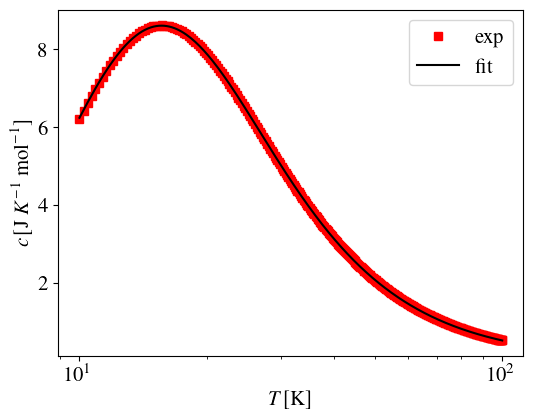

In [9]:
# 6.2. plot
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

plt.semilogx(kT.data, cexp.data, 'rs', label='exp')
plt.semilogx(kT.data, c.data, 'k-', label='fit')
plt.xlabel(r"$T[\rm{K}]$")
plt.ylabel(r"$c[{\rm J} ~ {K}^{-1} ~ {\rm mol}^{-1}]$")

plt.legend()
plt.show()


In [10]:
# 6.3. with the optimized parameters, calculate magnetization and susceptibility
kT = model.chidata[0].kT
B0 = model.chidata[0].B0
chiexp = model.chidata[0].measure

m, chi = model.measure_mchi(kT, B0)

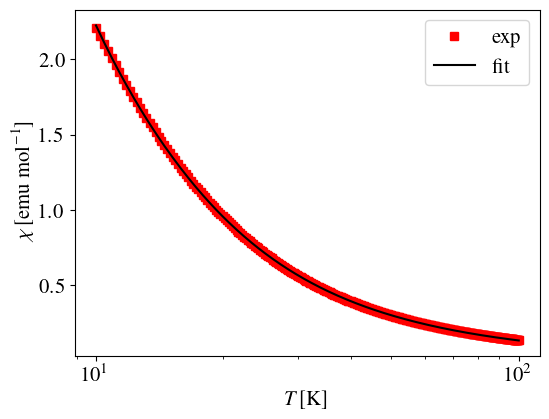

In [11]:
# 6.4. plot
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

plt.semilogx(kT.data, chiexp.data, 'rs', label='exp')
plt.semilogx(kT.data, chi.data, 'k-', label='fit')
plt.xlabel(r"$T[\rm{K}]$")
plt.ylabel(r"$\chi[{\rm emu} ~ {\rm mol}^{-1}]$")

plt.legend()
plt.show()
